In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import ot

from dtmrpy import DT_GMM

from time import time

device='cuda'


In [2]:
df = pd.read_pickle("data_files/dtmri_dataframe_HCP.pkl")
df = df.dropna(subset=df.columns[2:],how='all').copy()
df.reset_index(inplace=True, drop=True)
df


,sid,label,Cingulum_Frontal_Parahippocampal_L,Cingulum_Frontal_Parahippocampal_R,Cingulum_Frontal_Parietal_L,Cingulum_Frontal_Parietal_R,Cingulum_Parahippocampal_L,Cingulum_Parahippocampal_R,Cingulum_Parahippocampal_Parietal_L,Cingulum_Parahippocampal_Parietal_R,...,Fornix_L,Fornix_R,Superior_Longitudinal_Fasciculus1_L,Superior_Longitudinal_Fasciculus1_R,Superior_Longitudinal_Fasciculus2_L,Superior_Longitudinal_Fasciculus2_R,Superior_Longitudinal_Fasciculus3_L,Superior_Longitudinal_Fasciculus3_R,Uncinate_Fasciculus_L,Uncinate_Fasciculus_R
0,100206,M,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BA50...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC53...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC5D...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD67...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD77...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD85...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD94...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BDA2...,...,NaN,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA037...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA43A...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AAB46...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AB82D...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022ACDD3...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AED48...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B0488...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B1793...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B17A2...
1,100307,F,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BA50...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC53...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC5D...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD67...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD77...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD85...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD94...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BDA2...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022A992D...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA037...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA43A...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AAB46...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AB82D...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022ACDD3...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AED48...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B0488...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B1793...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B17A2...
2,100408,M,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BA50...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC53...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC5D...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD67...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD77...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD85...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD94...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BDA2...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022A992D...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA037...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA43A...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AAB46...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AB82E...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022ACDD3...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AED4A...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B0488...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B1793...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022B17A2...
3,100610,M,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BA50...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC53...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BC5D...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD67...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD77...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD85...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BD94...,<dtmrpy.dtmrpy.DT_GMM object at 0x00000229BDA2...,...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022A992D...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA037...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AA43A...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AAB46...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022AB82E...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022ACDD3...,<dtmrpy.dtmrpy.DT_GMM object at 0x0000022

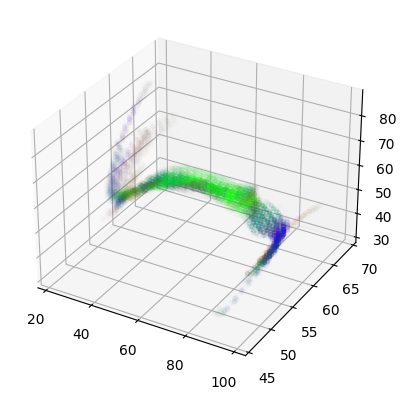

In [3]:
plt.figure().add_subplot(projection='3d')
df.at[3,'Cingulum_Frontal_Parahippocampal_R'].plot()
plt.show()

In [11]:
from scipy.spatial.distance import cdist

import geomstats
from geomstats.geometry.spd_matrices import SPDMatrices, SPDBuresWassersteinMetric

#for bures log map
from geomstats.geometry.symmetric_matrices import SymmetricMatrices
from geomstats.geometry.matrices import Matrices

space = SPDMatrices(3)
space.equip_with_metric(SPDBuresWassersteinMetric)



def bures_distance_matrix(Sigma_x,Sigma_y):
    Ux,Sx,Vx = torch.linalg.svd(Sigma_x)
    Sigma_x_sqrt = torch.matmul(torch.matmul(Ux,torch.diag_embed(torch.sqrt(Sx))),Vx)
    
    cross_term = torch.matmul(torch.matmul(Sigma_x_sqrt, Sigma_y.unsqueeze(1)),Sigma_x_sqrt.unsqueeze(0))
    Uc,Sc,Vc = torch.linalg.svd(cross_term)
    sqrt_cross_term = torch.matmul(torch.matmul(Uc,torch.diag_embed(torch.sqrt(Sc))),Vc)

    return torch.einsum('ijkk -> ij', Sigma_x.unsqueeze(0) + Sigma_y.unsqueeze(1) - 2*sqrt_cross_term).T #the transpose here should be fixed


def bures_distance_matrix2(Sigma_x,Sigma_y):
    Lx, Qx = torch.linalg.eigh(Sigma_x)
    Sigma_x_sqrt = Qx @ torch.diag_embed(torch.sqrt(Lx*(Lx>0))) @ Qx.mH
    
    cross_term = torch.matmul(torch.matmul(Sigma_x_sqrt, Sigma_y.unsqueeze(1)),Sigma_x_sqrt.unsqueeze(0))
    
    N=cross_term.shape[0]
    M=int(200000/cross_term.shape[1])
    
    for i in np.arange(0,N,M):
        Lc,Qc = torch.linalg.eigh(cross_term[i:(i+M)])
        cross_term[i:i+M] = Qc @ torch.diag_embed(torch.sqrt((Lc*(Lc>0)))) @ Qc.mH
    
    # Lc, Qc = torch.linalg.eigh(cross_term)
    # sqrt_cross_term = Qc @ torch.diag_embed(torch.sqrt(Lc)) @ Qc.mH

    return torch.einsum('ijkk -> ij', Sigma_x.unsqueeze(0) + Sigma_y.unsqueeze(1) - 2*cross_term).T #the transpose here should be fixed
    # return torch.einsum('ijkk -> ij', Sigma_x.unsqueeze(0) + Sigma_y.unsqueeze(1) - 2*sqrt_cross_term).T #the transpose here should be fixed


def wasserstein_type_distance(mu0,mu1,reg=1,reg_m=1):
    (weights0,means0,sigma0)=(mu0.weights_,mu0.means_,torch.tensor(mu0.covariances_).to('cuda'))
    (weights1,means1,sigma1)=(mu1.weights_,mu1.means_,torch.tensor(mu1.covariances_).to('cuda'))
    # print(len(weights0))
    # print(len(weights1))
    M = cdist(means0,means1)**2 + bures_distance_matrix2(sigma0,sigma1).cpu().numpy()
    
    # return M,ot.unbalanced.sinkhorn_unbalanced(weights0.reshape(-1),weights1.reshape(-1),M,reg=reg,reg_m=reg_m)
    a = weights0.reshape(-1)/np.sum(weights0)
    b = weights1.reshape(-1)/np.sum(weights1)
    # a = np.ones_like(weights0.reshape(-1))/weights0.shape[0]
    # b = np.ones_like(weights1.reshape(-1))/weights1.shape[0]
    return M, ot.emd(a,b,M)


def my_symmetric_sqrt(M, p):
    U,S,V = np.linalg.svd(M)
    return U@np.diag(S**p)@V
    

def my_bures_log(point, base_point):
        """Compute the Bures-Wasserstein logarithm map.

        Compute the Riemannian logarithm at point base_point,
        of point wrt the Bures-Wasserstein metric.
        This gives a tangent vector at point base_point.

        Parameters
        ----------
        point : array-like, shape=[..., n, n]
            Point.
        base_point : array-like, shape=[..., n, n]
            Base point.

        Returns
        -------
        log : array-like, shape=[..., n, n]
            Riemannian logarithm.
        """        
        # compute B^1/2(B^-1/2 A B^-1/2)B^-1/2 instead of sqrtm(AB^-1)
        sqrt_bp = my_symmetric_sqrt(base_point, 0.5)
        inv_sqrt_bp = my_symmetric_sqrt(base_point, -0.5)
        pdt = my_symmetric_sqrt(Matrices.mul(sqrt_bp, point, sqrt_bp),.5)
        sqrt_product = Matrices.mul(sqrt_bp, pdt, inv_sqrt_bp)
        transp_sqrt_product = Matrices.transpose(sqrt_product)
        return sqrt_product + transp_sqrt_product - 2 * base_point


def means_update(barycenter, measure_list, Pi_list):
        
    return np.mean(np.array([measure_list[i].means_.T@Pi_list[i].T@np.diag(1/barycenter.weights_.reshape(-1)) for i in range(len(measure_list))]),0).T

    
def covariance_update(space, barycenter, measure_list, Pi_list):
    
    Sigma0=space.projection(barycenter.covariances_)
    Sigma0_update = np.zeros_like(Sigma0)
    num_measures=len(measure_list)

    for p, measure in enumerate(measure_list):

        Pi=Pi_list[p]
        
        Sigma1=space.projection(measure.covariances_)

        for i in range(Sigma0.shape[0]):
            sigma0=Sigma0[i]
            ind = np.where(Pi[i]>0)[0]
            Sigma1_log = np.array([my_bures_log(sigma1,sigma0) for sigma1 in Sigma1[ind]])

            #Update Covariance
            temp=np.zeros((3,3))
            w_i=sum(Pi[i])
            for j in range(len(ind)):
                temp += Pi[i,ind[j]]*Sigma1_log[j]

            Sigma0_update[i] += space.metric.exp(temp/w_i,sigma0)/num_measures
            
    return Sigma0_update
    
    
def free_support_barycenter_update(measure_list, barycenter=None, N=200):
    
    if barycenter==None:
        # initialize weights
        # May need to change initial weights
        init_weights = np.ones((N,1))/N
        init_means = np.zeros(3)+np.random.normal(size=(N,3))
        # init_means = np.mean(measure_list[0].means_,0)+np.random.normal(size=(N,3))*np.std(measure_list[0].means_,0)
        init_covariances = SPDMatrices(3).random_point(N)
        barycenter = DT_GMM(weights=init_weights, means=init_means, covariances=init_covariances)
        # barycenter=measure_list[0]
        
    else:
    
        Pi_list = [wasserstein_type_distance(barycenter, measure)[1] for measure in measure_list]
        barycenter.means_ = means_update(barycenter, measure_list, Pi_list)
        barycenter.covariances_ = covariance_update(space, barycenter, measure_list, Pi_list) 
    
    return barycenter



###Sinkhorn versions
def sinkhorn_type_distance(mu0,mu1,reg=1,reg_m=1):
    (weights0,means0,sigma0)=(mu0.weights_,mu0.means_,torch.tensor(mu0.covariances_).to(device))
    (weights1,means1,sigma1)=(mu1.weights_,mu1.means_,torch.tensor(mu1.covariances_).to(device))

    M = cdist(means0,means1)**2 + bures_distance_matrix(sigma0,sigma1).cpu().numpy()
    
    # return M,ot.unbalanced.sinkhorn_unbalanced(weights0.reshape(-1),weights1.reshape(-1),M,reg=reg,reg_m=reg_m)
    a = weights0.reshape(-1)/np.sum(weights0)
    b = weights1.reshape(-1)/np.sum(weights1)
    return M, ot.sinkhorn(a,b,M, reg=0.1)


def free_support_sinkhorn_barycenter_update(measure_list, barycenter=None, N=200):
    
    if barycenter==None:
        # initialize weights
        # May need to change initial weights
        init_weights = np.ones((N,1))/N
        init_means = np.zeros(3)+np.random.normal(size=(N,3))
        # init_means = np.mean(measure_list[0].means_,0)+np.random.normal(size=(N,3))*np.std(measure_list[0].means_,0)
        init_covariances = SPDMatrices(3).random_point(N)
        barycenter = DT_GMM(weights=init_weights, means=init_means, covariances=init_covariances)
        # barycenter=measure_list[0]
        
    else:
    
        Pi_list = [sinkhorn_type_distance(barycenter, measure, reg=0.1)[1] for measure in measure_list]
        barycenter.means_ = means_update(barycenter, measure_list, Pi_list)
        barycenter.covariances_ = covariance_update(space, barycenter, measure_list, Pi_list) 
    
    return barycenter

In [5]:
mu0=df['Cingulum_Frontal_Parahippocampal_R'][2]
mu1=df['Cingulum_Frontal_Parahippocampal_R'][3]

In [6]:
M,Pi = wasserstein_type_distance(mu0,mu1)
M2,Pi2 = sinkhorn_type_distance(mu0,mu1)

C:\Users\micha\anaconda3\envs\gpu_compute_env\Lib\site-packages\ot\bregman.py:503: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
C:\Users\micha\anaconda3\envs\gpu_compute_env\Lib\site-packages\ot\bregman.py:503: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
C:\Users\micha\anaconda3\envs\gpu_compute_env\Lib\site-packages\ot\bregman.py:511: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


(353, 2434)

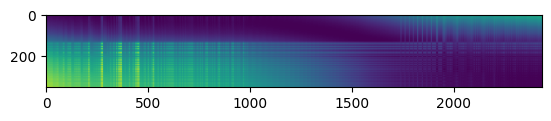

In [7]:
plt.imshow(M)

M.shape


(353, 2434)

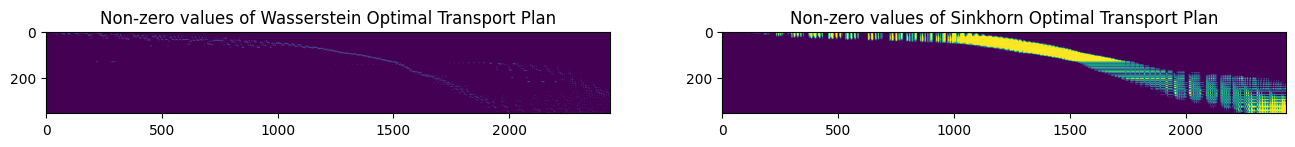

In [8]:
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(Pi>0)
plt.title("Non-zero values of Wasserstein Optimal Transport Plan")

plt.subplot(1,2,2)
plt.imshow(Pi2>0)
plt.title("Non-zero values of Sinkhorn Optimal Transport Plan")

Pi.shape


In [9]:
measure_list=[]

tract = df.columns[2]

for subject in df[tract]:
    if type(subject)==DT_GMM:
        measure_list.append(subject)

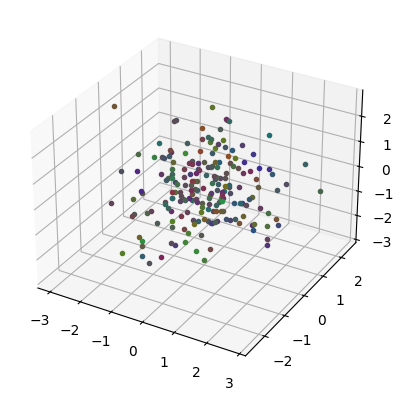

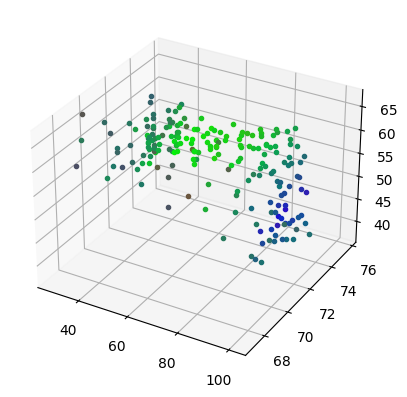

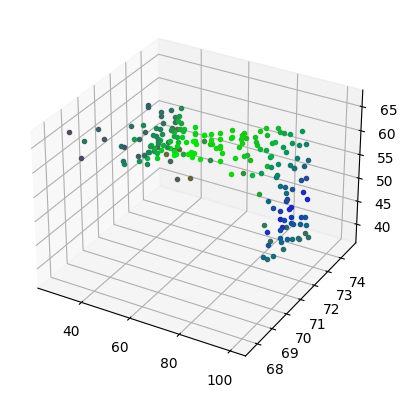

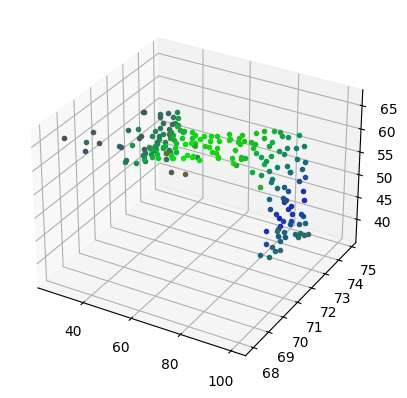

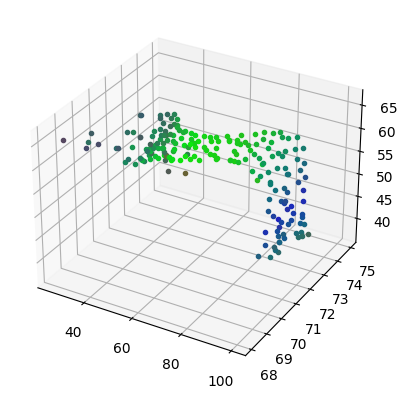

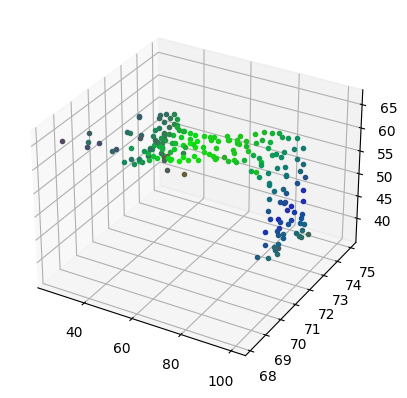

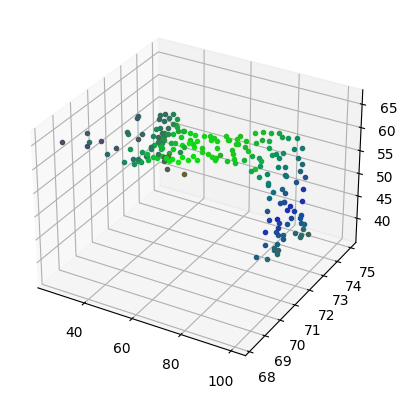

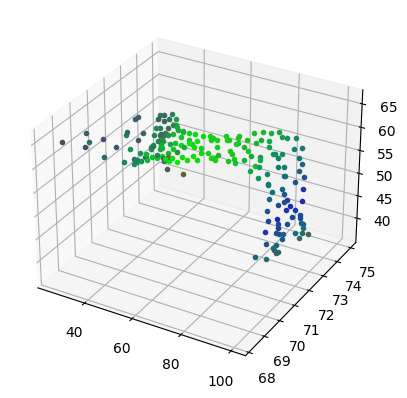

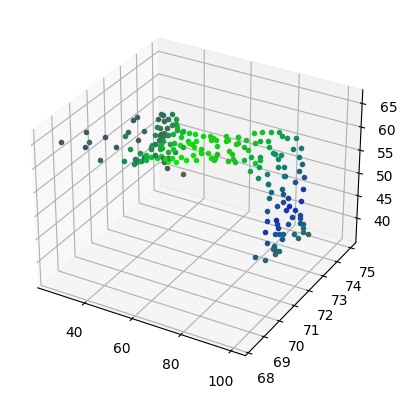

In [12]:
barycenter=free_support_barycenter_update(measure_list)

plt.figure().add_subplot(projection='3d')
barycenter.plot()
plt.show()

for i in range(8):
    
    barycenter=free_support_barycenter_update(measure_list, barycenter)
    # barycenter=free_support_sinkhorn_barycenter_update(measure_list, barycenter)
    
    plt.figure().add_subplot(projection='3d')
    barycenter.plot()
    plt.show()


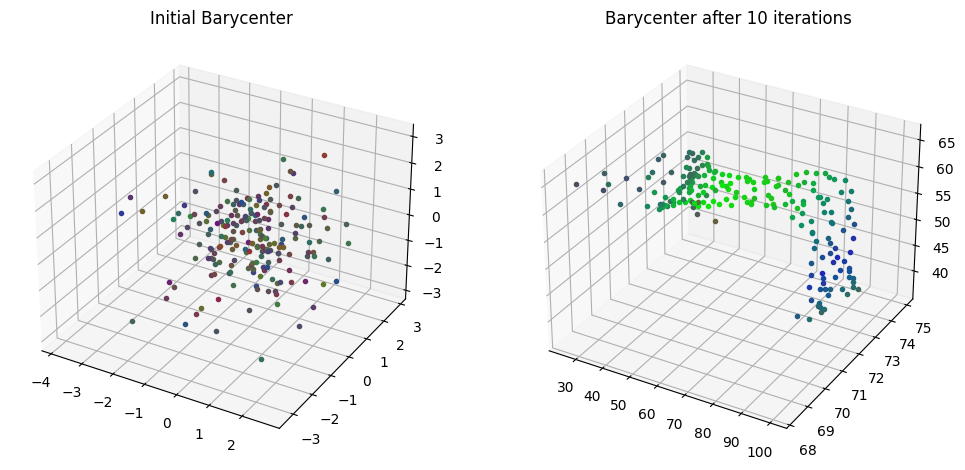

In [16]:
fig = plt.figure(figsize = (12,6))

ax = fig.add_subplot(121, projection='3d')
free_support_barycenter_update(measure_list).plot()
ax.set_title("Initial Barycenter")

ax = fig.add_subplot(122, projection='3d')
barycenter.plot()
ax.set_title("Barycenter after 10 iterations")

plt.show()
# plt.savefig("data_files/images/Barycenter_example.png",bbox_inches='tight')

np.save("data_files/hcp/"+tract+"_barycenter", barycenter, allow_pickle=True)


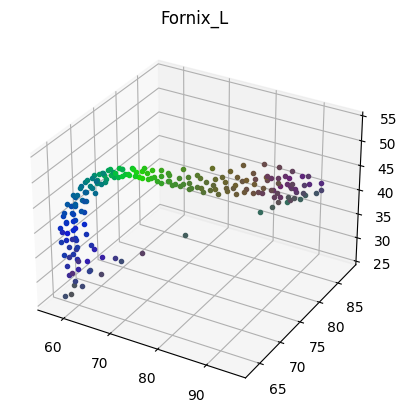

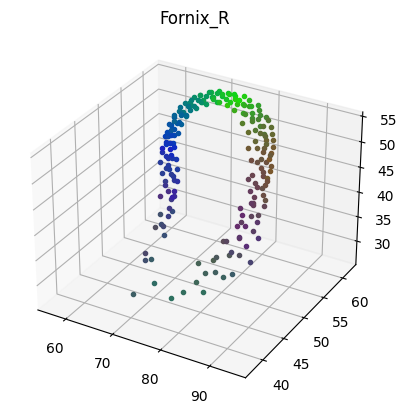

C:\Users\micha\anaconda3\envs\gpu_compute_env\Lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


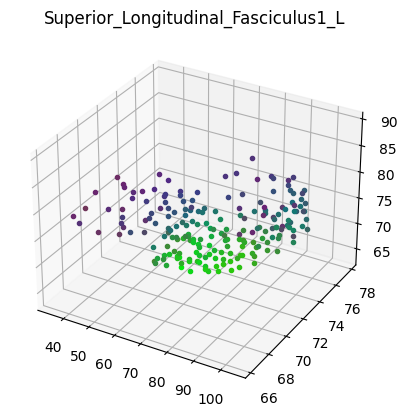

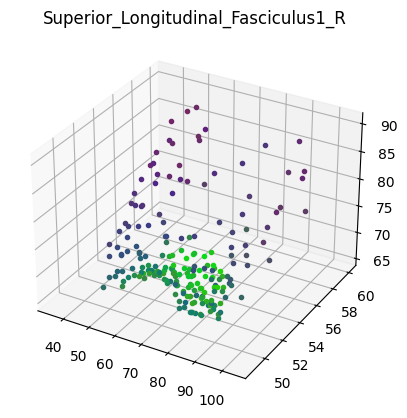

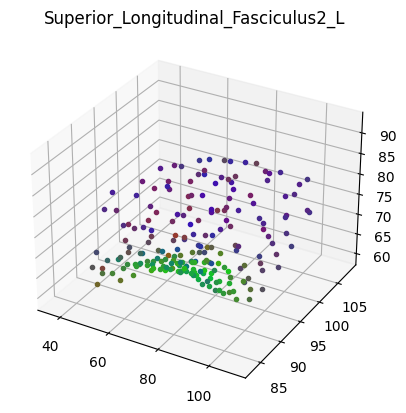

C:\Users\micha\AppData\Local\Temp\ipykernel_3292\1260920397.py:122: RuntimeWarning: invalid value encountered in divide
  Sigma0_update[i] += space.metric.exp(temp/w_i,sigma0)/num_measures
C:\Users\micha\anaconda3\envs\gpu_compute_env\Lib\site-packages\ot\lp\__init__.py:354: UserWarning: Problem infeasible. Check that a and b are in the simplex
  result_code_string = check_result(result_code)


LinAlgError: Eigenvalues did not converge

In [22]:
for tract in df.columns[16:]:    
    labels_list=[]
    measure_list=[]

    for i, subject in enumerate(df[tract]):
        if type(subject)==DT_GMM:
            measure_list.append(subject)

    y=np.array(labels_list)
    
    for i in range(8):

        barycenter=free_support_barycenter_update(measure_list, barycenter)
        
    plt.figure().add_subplot(projection='3d')
    barycenter.plot()
    plt.title(tract)
    plt.show()
        
    np.save("data_files/hcp/"+tract+"_barycenter", barycenter, allow_pickle=True)
